### Objective
The goal of this project is to develop a predictive model for ShopSense's E-Commerce Revenue Index using historical order and transaction data. By analyzing key sales metrics, we aim to identify trends, forecast revenue, and optimize decision-making for online retail performance.

The model is trained on data up to 2022 Q3 and tested on 2022 Q4, evaluating multiple machine learning models to determine the most accurate revenue predictor. This project provides insights into the factors driving e-commerce revenue, helping businesses make data-driven strategic decisions.

In [2]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Data Loading

In [8]:
order_numbers=pd.read_excel('retails_data.xlsx', sheet_name="orders")
transaction_data=pd.read_excel('retails_data.xlsx', sheet_name="transactions")
reported_data=pd.read_excel('retails_data.xlsx', sheet_name="reported_data")

In [10]:
#Displaying few rows
print(order_numbers.head(2))
print()
print(transaction_data.head(2))
print()
print(reported_data.head(2))

        date  order_number
0 2018-01-07      33841906
1 2018-01-22      34008921

        date  total_spend_index  weekly_active_users_index
0 2018-01-01           0.052537                   1.563906
1 2018-01-02           0.839176                   1.628579

    period start_date   end_date  revenue_index
0  2018 Q1 2018-01-01 2018-02-28     100.000000
1  2018 Q2 2018-03-01 2018-06-30     253.521127


### Data Exploration

In [328]:
#Decting outliers
Outliers=transaction_data[['total_spend_index','weekly_active_users_index']]

# Detecting outliers based on Interquartile Range (IQR) Method
def detect_outliers_iqr(data, columns):
    outliers_iqr = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        outliers_iqr[col] = outliers[col]
    return outliers_iqr

outliers_iqr = detect_outliers_iqr(transaction_data, Outliers)

# Display outliers for each column
for col, outliers in outliers_iqr.items():
    print(f'Outliers in {col}:\n{outliers}\n')

Outliers in total_spend_index:
974      429.327569
1061     441.984122
1064     902.055981
1093     612.731265
1191     710.369272
1219     574.391529
1247     606.454682
1338     517.895011
1372     416.940751
1400     447.753643
1414     446.551023
1425     711.751097
1426     455.205028
1428    1311.692726
1429     506.231346
1442     472.481489
1449     492.798606
1458     719.066164
1464     468.931476
1470     441.002709
1491     461.480671
1505     445.067194
1512     418.503994
1519     424.648792
1554     442.305674
1561     429.760554
1569     499.785567
1575     488.409914
1583     634.938043
1589     453.720232
1596     453.915170
1603     519.132056
1610     462.090539
1611     527.075129
1617     633.034114
1624     420.924717
1631     428.960559
1638     439.328476
1645     441.396209
1652     448.933644
1673     468.420875
1789     433.960391
1792     749.566324
Name: total_spend_index, dtype: float64

Outliers in weekly_active_users_index:
Series([], Name: weekly_activ

### Data Preprocessing & Feature Engineering

In [329]:
# 1. Cleaning order_numbers
order_numbers = order_numbers.sort_values(by="date").reset_index(drop=True) #sort by date

In [330]:
## Calculate day order counts 
order_numbers["order_number"].diff().fillna(0).head(20) # Understanding 'order_number' difference to remove bad data

0           0.0
1      167015.0
2      388547.0
3       36964.0
4      144933.0
5      479961.0
6       87922.0
7       44491.0
8      151257.0
9       90683.0
10    1359803.0
11   -1310484.0
12      62395.0
13      60110.0
14    2987920.0
15   -3033672.0
16     191173.0
17     168069.0
18     229014.0
19      16925.0
Name: order_number, dtype: float64

In [331]:
# The order numbers should always increase over time (because order number only goes up)
order_numbers_cleaned = order_numbers[order_numbers["order_number"].diff().fillna(0) >= 0]

In [332]:
# Calculate day order counts
order_numbers_cleaned["day_order_count"] = order_numbers_cleaned["order_number"].diff().fillna(0).astype(int)
order_numbers_cleaned

,date,order_number,day_order_count
0,2018-01-07,33841906,0
1,2018-01-22,34008921,167015
2,2018-01-25,34397468,388547
3,2018-02-06,34434432,36964
4,2018-02-08,34579365,144933
...,...,...,...
851,2022-12-26,89053562,47918
852,2022-12-27,89078365,24803
853,2022-12-28,89109007,30642
854,2022-12-29,89139373,30366


In [333]:
# Assign period to the cleaned 'order_numbers' data
reported_periods = reported_data[["start_date", "end_date"]]
reported_periods["period"] = reported_data["period"]

def assign_quarter(date):
    for _, row in reported_periods.iterrows():
        if row["start_date"] <= date <= row["end_date"]:
            return row["period"]
    return None

order_numbers_cleaned["period"] = order_numbers_cleaned["date"].apply(assign_quarter)

In [334]:
# Combine daily orders into quarterly totals
quarterly_order_counts = (
    order_numbers_cleaned.groupby("period")["day_order_count"].sum().reset_index()
)
quarterly_order_counts.rename(columns={"day_order_count": "total_orders"}, inplace=True)
quarterly_order_counts

,period,total_orders
0,2018 Q1,737459
1,2018 Q2,3178413
2,2018 Q3,1324544
3,2018 Q4,3065524
4,2019 Q1,1321037
5,2019 Q2,3048557
6,2019 Q3,1674117
7,2019 Q4,3601784
8,2020 Q1,1641438
9,2020 Q2,4042425


In [335]:
# 2. transaction_data

#Removing Outliers
def remove_outliers_iteratively(data, columns, threshold=1.5):
    previous_shape = data.shape[0]
    while True:
        # Detect outliers based on IQR
        outliers_iqr = detect_outliers_iqr(data, columns)
        
        if all(outliers.empty for outliers in outliers_iqr.values()):
            break
        
        for col, outliers in outliers_iqr.items():
            data = data[~data.index.isin(outliers.index)]
        
        if data.shape[0] == previous_shape:
            break
        
        previous_shape = data.shape[0]
        
    return data

cleaned_data = remove_outliers_iteratively(transaction_data, ['total_spend_index', 'weekly_active_users_index'])

# Checking the final shape
print(f"Shape after removal: {cleaned_data.shape}")

# checking if any outliers after removal
outliers_after_removal = detect_outliers_iqr(cleaned_data, ['total_spend_index', 'weekly_active_users_index'])
print(outliers_after_removal)


Shape after removal: (1767, 3)
{'total_spend_index': Series([], Name: total_spend_index, dtype: float64), 'weekly_active_users_index': Series([], Name: weekly_active_users_index, dtype: float64)}


In [336]:
# Normalize 'total_spend_index' using 'weekly_active_users_index' - To find how much a single user spends per day on average.This helps in better revenue prediction 

transaction_data["normalized_spend"] = (
    transaction_data["total_spend_index"] / transaction_data["weekly_active_users_index"])

# Assign period to 'transaction_data'
transaction_data["period"] = transaction_data["date"].apply(assign_quarter)

# Combine normalized spend into quarterly data
quarterly_transaction_data = (
    transaction_data.groupby("period")["normalized_spend"].mean().reset_index())

quarterly_transaction_data.rename(columns={"normalized_spend": "avg_normalized_spend"}, inplace=True)


In [337]:
quarterly_transaction_data

,period,avg_normalized_spend
0,2018 Q1,0.409458
1,2018 Q2,0.677376
2,2018 Q3,0.747407
3,2018 Q4,0.732159
4,2019 Q1,0.549906
5,2019 Q2,0.688640
6,2019 Q3,0.680344
7,2019 Q4,0.775569
8,2020 Q1,0.578690
9,2020 Q2,0.761075


###### 1. Cleaning Order Numbers:

- Removed inconsistencies where order numbers were out of sequence.

- Calculated total_orders per quarter based on order number differences.

###### 2. Revoming Outliers & Normalizing Transaction Data:

- Removed Outliers by Interquartile Range (IQR) Method.
- total_spend_index was divided by weekly_active_users_index to get average spend per user to adjust for variations in user activity.

###### 3. Quarterly Aggregation:

- Converted daily data to quarterly summaries to match the revenue reporting period.

### Merging

In [338]:
# Merge 'quarterly_order_counts' and 'quarterly_transaction_data' with 'reported_data' for modeling
final_reported_data = reported_data.merge(
    quarterly_order_counts, on="period", how="left").merge(
    quarterly_transaction_data, on="period", how="left")

In [339]:
final_reported_data

,period,start_date,end_date,revenue_index,total_orders,avg_normalized_spend
0,2018 Q1,2018-01-01,2018-02-28,100.000000,737459,0.409458
1,2018 Q2,2018-03-01,2018-06-30,253.521127,3178413,0.677376
2,2018 Q3,2018-07-01,2018-08-31,139.788732,1324544,0.747407
3,2018 Q4,2018-09-01,2018-12-31,306.161972,3065524,0.732159
4,2019 Q1,2019-01-01,2019-02-28,117.693662,1321037,0.549906
5,2019 Q2,2019-03-01,2019-06-30,294.102113,3048557,0.688640
6,2019 Q3,2019-07-01,2019-08-31,156.514085,1674117,0.680344
7,2019 Q4,2019-09-01,2019-12-31,359.947183,3601784,0.775569
8,2020 Q1,2020-01-01,2020-02-29,148.063380,1641438,0.578690
9,2020 Q2,2020-03-01,2020-06-30,289.788732,4042425,0.761075


### Exploratory Data Analysis

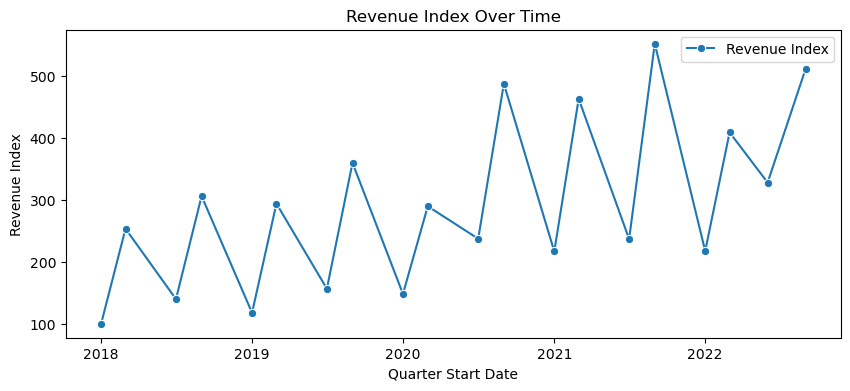

In [340]:
# Understanding Revenue Trends over time from Reported Data
plt.figure(figsize=(10, 4))
sns.lineplot(data=reported_data, x="start_date", y="revenue_index", marker="o", label="Revenue Index")
plt.title("Revenue Index Over Time")
plt.xlabel("Quarter Start Date")
plt.ylabel("Revenue Index")
plt.show()

**Observations:**
- Overall Growth: Revenue index shows an increasing trend from 2018 to 2022.
- Seasonal Fluctuations: Recurring spikes and dips suggest seasonal trends.
- Strong Growth in 2021-2022: Revenue peaked significantly during this period.
- Volatility: Some quarters show sudden declines after peaks, indicating variability.

### Modelling

In [341]:
#Encoding period variable

# Extract year and quarter from the "period" column
final_reported_data["year"] = final_reported_data["period"].str[:4].astype(int)
final_reported_data["quarter"] = final_reported_data["period"].str[-1].astype(int)

# Encode the period as a continuous numeric feature
final_reported_data["period_encoded"] = final_reported_data["year"] + (final_reported_data["quarter"] / 10)

# Drop the temporary columns
final_reported_data.drop(columns=["year", "quarter"], inplace=True)
final_reported_data

,period,start_date,end_date,revenue_index,total_orders,avg_normalized_spend,period_encoded
0,2018 Q1,2018-01-01,2018-02-28,100.000000,737459,0.409458,2018.1
1,2018 Q2,2018-03-01,2018-06-30,253.521127,3178413,0.677376,2018.2
2,2018 Q3,2018-07-01,2018-08-31,139.788732,1324544,0.747407,2018.3
3,2018 Q4,2018-09-01,2018-12-31,306.161972,3065524,0.732159,2018.4
4,2019 Q1,2019-01-01,2019-02-28,117.693662,1321037,0.549906,2019.1
5,2019 Q2,2019-03-01,2019-06-30,294.102113,3048557,0.688640,2019.2
6,2019 Q3,2019-07-01,2019-08-31,156.514085,1674117,0.680344,2019.3
7,2019 Q4,2019-09-01,2019-12-31,359.947183,3601784,0.775569,2019.4
8,2020 Q1,2020-01-01,2020-02-29,148.063380,1641438,0.578690,2020.1
9,2020 Q2,2020-03-01,2020-06-30,289.788732,4042425,0.761075,2020.2


In [342]:
# Used data up to 2022 Q3 for training and 2022 Q4 for testing
train_data = final_reported_data[final_reported_data["period"] != "2022 Q4"]
test_data = final_reported_data[final_reported_data["period"] == "2022 Q4"]

In [343]:
print(train_data.shape)
print(test_data.shape)

(19, 7)
(1, 7)


In [344]:
# Define features and target variable
X_train = train_data[["period_encoded", "total_orders", "avg_normalized_spend"]]
y_train = train_data["revenue_index"]

X_test = test_data[["period_encoded", "total_orders", "avg_normalized_spend"]]
y_test = test_data["revenue_index"]

**Linear Regression Model**

In [345]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)
#r2 = r2_score(y_test, y_pred_lr)
percentage_error = abs((y_test.values[0] - y_pred_lr[0]) / y_test.values[0]) * 100

print(f'Mean Squared Error (MSE): {round (mse,2)}')
print(f'Mean Absolute Error (MAE): {round (mae,2)}')
print(f'Percentage Error: {round(percentage_error,2)}%')
#print(f'R-squared (R²): {r2}') # variance might be zero because test data contains only 1 row 

print("\nPredictions for 2022 Q4 Revenue Index:")
print("Actual:", y_test.values)
print("Predicted:", y_pred_lr)


Mean Squared Error (MSE): 37438.89
Mean Absolute Error (MAE): 193.49
Percentage Error: 37.79%

Predictions for 2022 Q4 Revenue Index:
Actual: [512.07978902]
Predicted: [318.5884628]


The dataset is small and may have a non-linear relationship, making linear regression less effective for accurate predictions. 

**DecisionTreeRegressor Model**

In [346]:
DT_model = DecisionTreeRegressor(random_state=42)
DT_model.fit(X_train, y_train)
y_pred_DT=DT_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_DT)
mae = mean_absolute_error(y_test, y_pred_DT)
percentage_error = abs((y_test.values[0] - y_pred_DT[0]) / y_test.values[0]) * 100

print(f'Mean Squared Error (MSE): {round (mse,2)}')
print(f'Mean Absolute Error (MAE): {round (mae,2)}')
print(f'Percentage Error: {round(percentage_error,2)}%')

print("\nPredictions for 2022 Q4 Revenue Index:")
print("Actual:", y_test.values)
print("Predicted:", y_pred_DT)

Mean Squared Error (MSE): 2371.64
Mean Absolute Error (MAE): 48.7
Percentage Error: 9.51%

Predictions for 2022 Q4 Revenue Index:
Actual: [512.07978902]
Predicted: [463.38028169]


**Random Forest Regressor Model**

In [347]:
RF = RandomForestRegressor(n_estimators=1, random_state=1)
RF.fit(X_train, y_train)
y_RF_pred = RF.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_RF_pred)
mae = mean_absolute_error(y_test, y_RF_pred)
percentage_error = abs((y_test.values[0] - y_RF_pred[0]) / y_test.values[0]) * 100

print(f'Mean Squared Error (MSE): {round (mse,2)}')
print(f'Mean Absolute Error (MAE): {round (mae,2)}')
print(f'Percentage Error: {round(percentage_error,2)}%')

print("\nPredictions for 2022 Q4 Revenue Index:")
print("Actual:", y_test.values)
print("Predicted:", y_RF_pred)

Mean Squared Error (MSE): 591.25
Mean Absolute Error (MAE): 24.32
Percentage Error: 4.75%

Predictions for 2022 Q4 Revenue Index:
Actual: [512.07978902]
Predicted: [487.76408451]


### Conclusion
Random Forest Regressor model predicted well for 2022 Q4 Revenue Index after evaluating several models.